# Mini Project: Leveraging ML for Revenue Optimization via Strategic Couponing

## Objective
We develop a predictive model that decides whether a customer should receive a **€5 voucher** after their first purchase.  
The goal is to maximize **expected revenue**.

### Business payoff structure (given)
- If we **send a voucher** to a customer who **would not reorder** (true churn), then in **25%** of cases the voucher triggers a purchase with **€10** average order value  
  ⇒ the net uplift is **€1.25** per such customer.
- If we **send a voucher** to a customer who **would reorder anyway**, we lose **€5** (discount we did not need to give).
- If we **do not send** a voucher, revenue impact is **€0**.

Therefore, we will optimize the model and its decision threshold directly for **expected revenue**.

Name : Franzi Nagel
Name : Alexander Unger

# 1. Data inspection

## 1.1 Load training data

We load the training dataset and verify shape, schema, and the target definition.


In [88]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [89]:
import os

my_dire = os.getcwd()
train = pd.read_csv('train.csv', sep=';')

## 1.2 Feature dictionary check

We compare observed columns to the data dictionary to detect missing or unexpected fields early.


In [90]:
train.columns.tolist()
train.dtypes


customernumber           int64
date                    object
salutation               int64
title                    int64
domain                   int64
datecreated             object
newsletter               int64
model                    int64
paymenttype              int64
deliverytype             int64
invoicepostcode          int64
delivpostcode           object
voucher                  int64
advertisingdatacode     object
case                     int64
numberitems              int64
gift                     int64
entry                    int64
points                   int64
shippingcosts            int64
deliverydatepromised    object
deliverydatereal        object
weight                   int64
remi                     int64
cancel                   int64
used                     int64
w0                       int64
w1                       int64
w2                       int64
w3                       int64
w4                       int64
w5                       int64
w6      

## 1.3 Target distribution

Since business value is asymmetric, we inspect class balance but optimize later for expected revenue.


In [91]:
target_col = "target90"
train[target_col].value_counts(dropna=False), train[target_col].mean()


(target90
 0    26377
 1     6051
 Name: count, dtype: int64,
 0.1865980017269027)

## 1.4 Missing values overview

We quantify missingness to guide feature engineering and imputation decisions.


In [92]:
missing = train.isna().mean().sort_values(ascending=False)
missing[missing > 0].head(30)


delivpostcode          0.957074
advertisingdatacode    0.798847
dtype: float64

In [93]:
train.isna().sum().sort_values(ascending=False)


delivpostcode           31036
advertisingdatacode     25905
customernumber              0
deliverydatepromised        0
weight                      0
remi                        0
cancel                      0
used                        0
w0                          0
w1                          0
w2                          0
w3                          0
w4                          0
w5                          0
w6                          0
w7                          0
w8                          0
w9                          0
w10                         0
deliverydatereal            0
shippingcosts               0
date                        0
paymenttype                 0
salutation                  0
title                       0
domain                      0
datecreated                 0
newsletter                  0
model                       0
deliverytype                0
points                      0
invoicepostcode             0
voucher                     0
case      

## 1.5 Basic integrity checks

We run lightweight checks to catch impossible values and potential data issues before modeling.


In [94]:
checks = {
    "negative_weight": (train["weight"] < 0).sum() if "weight" in train.columns else None,
    "negative_numberitems": (train["numberitems"] < 0).sum() if "numberitems" in train.columns else None,
    "negative_remi": (train["remi"] < 0).sum() if "remi" in train.columns else None,
    "negative_cancel": (train["cancel"] < 0).sum() if "cancel" in train.columns else None,
    "negative_used": (train["used"] < 0).sum() if "used" in train.columns else None,
}
checks


{'negative_weight': 0,
 'negative_numberitems': 0,
 'negative_remi': 0,
 'negative_cancel': 0,
 'negative_used': 0}

## 1.6 Date parsing

We convert date-like columns to datetime to enable duration features and consistency checks.


In [95]:
# Example: account created should not be after first order (if both exist)
if "date" in train.columns and "datecreated" in train.columns:
    invalid_account_age = (train["date"] < train["datecreated"]).sum()
    invalid_account_age


## 1.7 Univariate EDA (light)

We summarize numeric variables and inspect a small set of distributions to identify skew and outliers.


In [96]:
num_cols = train.select_dtypes(include=[np.number]).columns
train[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
customernumber,32428.0,33389.298569,19148.090449,1.0,16802.75,33552.5,50034.25,66251.0
salutation,32428.0,0.541569,0.657044,0.0,0.00,0.0,1.00,2.0
title,32428.0,0.006969,0.083192,0.0,0.00,0.0,0.00,1.0
domain,32428.0,7.517115,3.683945,0.0,4.00,9.0,11.00,12.0
newsletter,32428.0,0.169483,0.375184,0.0,0.00,0.0,0.00,1.0
model,32428.0,1.646910,0.825981,1.0,1.00,1.0,2.00,3.0
paymenttype,32428.0,1.000987,1.092677,0.0,0.00,1.0,2.00,3.0
deliverytype,32428.0,0.201955,0.401465,0.0,0.00,0.0,0.00,1.0
invoicepostcode,32428.0,48.752282,24.361425,0.0,30.00,47.0,66.00,99.0
voucher,32428.0,0.162020,0.368475,0.0,0.00,0.0,0.00,1.0


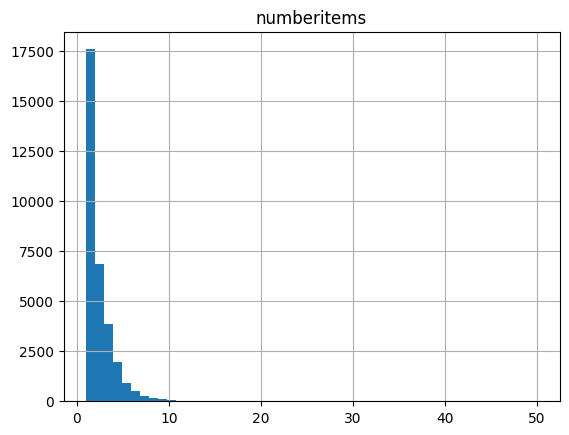

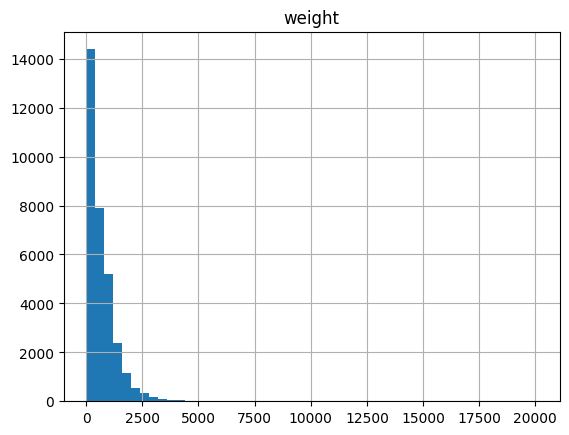

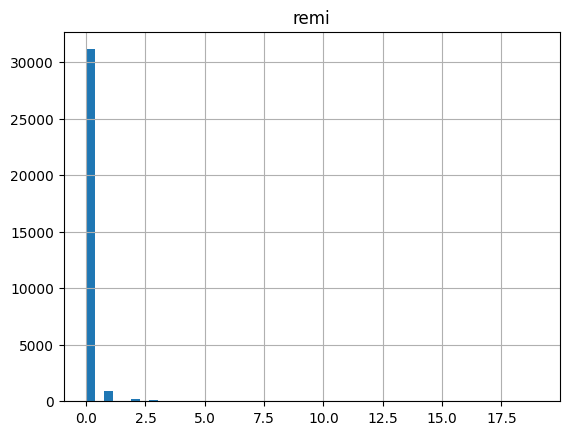

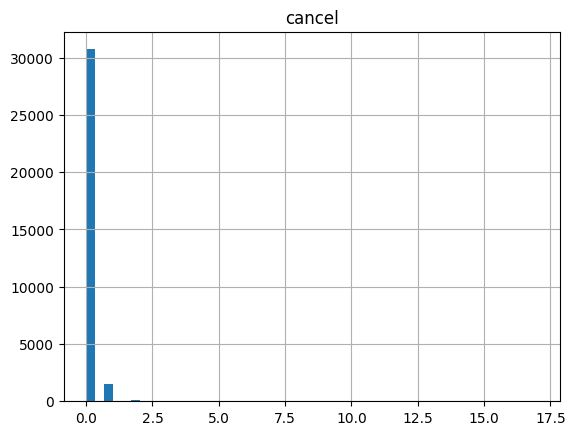

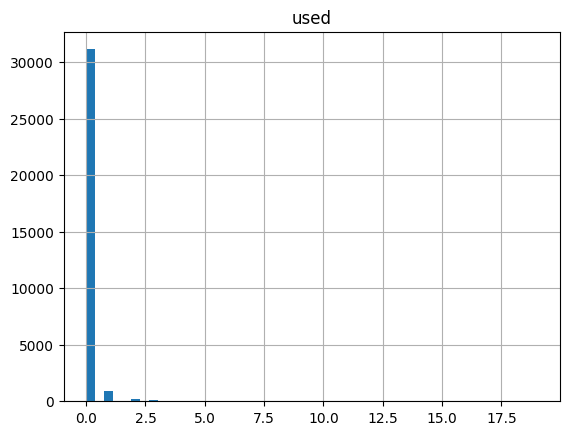

In [97]:
plot_cols = [c for c in ["numberitems", "weight", "remi", "cancel", "used"] if c in train.columns]

for c in plot_cols:
    plt.figure()
    train[c].hist(bins=50)
    plt.title(c)
    plt.show()


## 1.8 Categorical checks

We inspect low-cardinality categorical variables to confirm coding and spot rare categories.


In [98]:
cat_candidates = ["salutation", "title", "newsletter", "model", "paymenttype", "deliverytype", "voucher", "gift", "entry", "points", "shippingcosts", "domain", "case"]
for c in [x for x in cat_candidates if x in train.columns]:
    print("\n", c)
    print(train[c].value_counts(dropna=False).head(20))



 salutation
salutation
0    17840
1    11614
2     2974
Name: count, dtype: int64

 title
title
0    32202
1      226
Name: count, dtype: int64

 newsletter
newsletter
0    26932
1     5496
Name: count, dtype: int64

 model
model
1    18808
3     7358
2     6262
Name: count, dtype: int64

 paymenttype
paymenttype
0    15063
1     6549
2     6537
3     4279
Name: count, dtype: int64

 deliverytype
deliverytype
0    25879
1     6549
Name: count, dtype: int64

 voucher
voucher
0    27174
1     5254
Name: count, dtype: int64

 gift
gift
0    32280
1      148
Name: count, dtype: int64

 entry
entry
0    18982
1    13446
Name: count, dtype: int64

 points
points
0    32428
Name: count, dtype: int64

 shippingcosts
shippingcosts
0    27544
1     4884
Name: count, dtype: int64

 domain
domain
12    7734
9     6953
4     6627
8     3694
11    1422
5     1311
2     1196
0     1173
1     1139
6      548
3      381
10     137
7      113
Name: count, dtype: int64

 case
case
4    8648
3    7125
1 

## 1.10 EDA conclusions

The dataset is moderately imbalanced (≈18.7% positive class), contains strong sparsity in some variables, and shows heavy skew and outliers in count-based features.


## 2. Visual exploratory analysis

We visualize selected raw variables to motivate later preprocessing and feature engineering choices.



### 2.1 Target distribution

We confirm class imbalance to justify revenue-based optimization rather than accuracy.


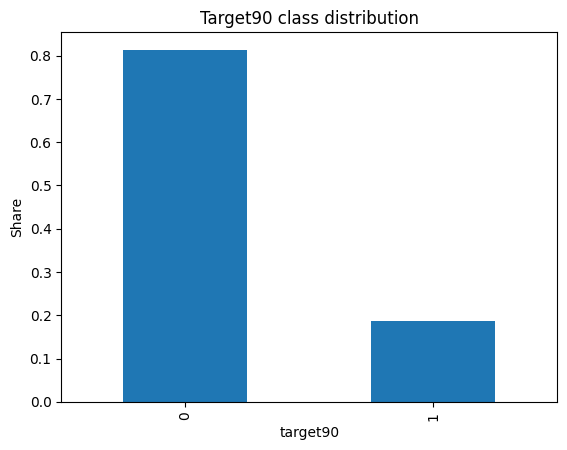

In [99]:
train["target90"].value_counts(normalize=True).plot(
    kind="bar",
    title="Target90 class distribution"
)
plt.ylabel("Share")
plt.show()


### 2.2 Account tenure and reorder behavior

Customer tenure is expected to proxy loyalty and experience.

<Figure size 640x480 with 0 Axes>

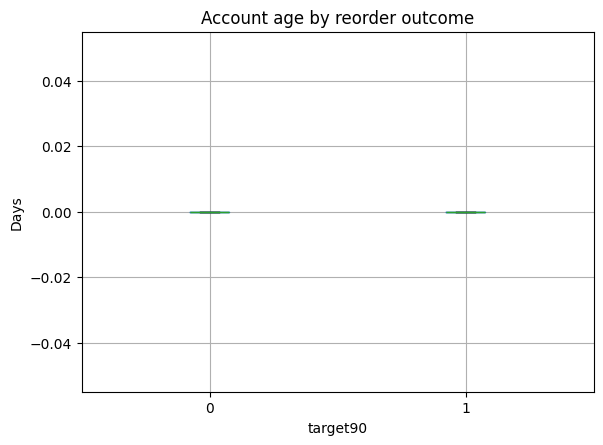

In [100]:
account_age_raw = (
    pd.to_datetime(train["date"], errors="coerce")
    - pd.to_datetime(train["datecreated"], errors="coerce")
).dt.days

plt.figure()
pd.DataFrame({
    "account_age_days": account_age_raw,
    "target90": train["target90"]
}).boxplot(
    column="account_age_days",
    by="target90",
    showfliers=False
)
plt.title("Account age by reorder outcome")
plt.suptitle("")
plt.ylabel("Days")
plt.show()


### 2.3 Order size and shipment weight

These variables are highly skewed and may influence reorder probability.


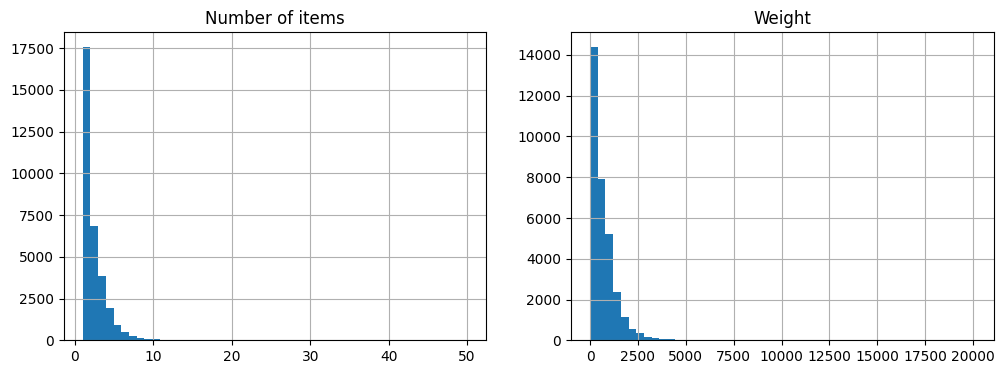

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train["numberitems"].hist(bins=50, ax=axes[0])
axes[0].set_title("Number of items")

train["weight"].hist(bins=50, ax=axes[1])
axes[1].set_title("Weight")

plt.show()


### 2.4 Product-category purchase patterns

Most category counts are sparse with long tails.



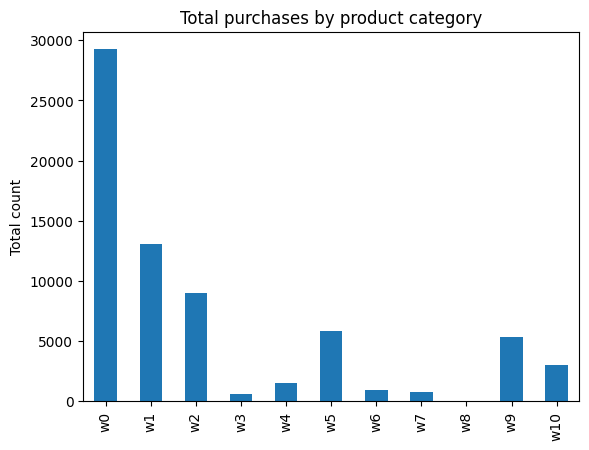

In [102]:
w_cols = [f"w{i}" for i in range(11)]

train[w_cols].sum().plot(
    kind="bar",
    title="Total purchases by product category"
)
plt.ylabel("Total count")
plt.show()



### 2.5 Promised delivery timing

Delivery expectations may influence customer satisfaction and repeat purchases.


<Figure size 640x480 with 0 Axes>

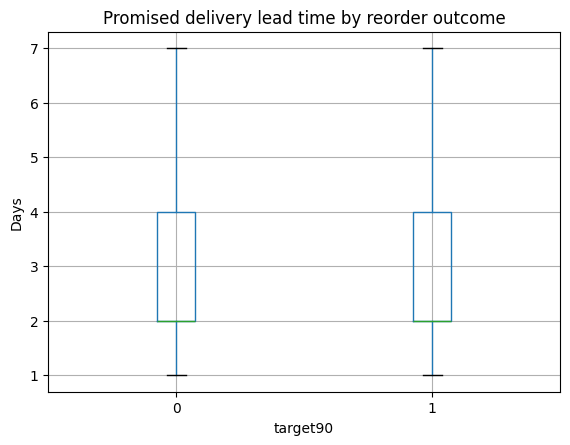

In [103]:
promised_lead_time_raw = (
    pd.to_datetime(train["deliverydatepromised"], errors="coerce")
    - pd.to_datetime(train["date"], errors="coerce")
).dt.days

plt.figure()
pd.DataFrame({
    "promised_lead_time": promised_lead_time_raw,
    "target90": train["target90"]
}).boxplot(
    column="promised_lead_time",
    by="target90",
    showfliers=False
)
plt.title("Promised delivery lead time by reorder outcome")
plt.suptitle("")
plt.ylabel("Days")
plt.show()


### 2.6 Incentives and service indicators

We inspect whether basic service and incentive variables differ by reorder behavior.


In [104]:
cat_vars = [
    "salutation", "title", "domain", "newsletter", "model",
    "paymenttype", "deliverytype", "voucher", "gift",
    "entry", "shippingcosts", "case"
]

for c in cat_vars:
    print(c, train[c].nunique())


salutation 3
title 2
domain 13
newsletter 2
model 3
paymenttype 4
deliverytype 2
voucher 2
gift 2
entry 2
shippingcosts 2
case 5


## 3. Data transformations and feature engineering

We construct a leakage-safe baseline feature set and clearly separate optional transformations for later robustness checks.


### 3.1 Feature removal (baseline)

We remove identifiers, constant variables, and features with extreme missingness or leakage risk.


In [105]:
# Copy to avoid modifying raw inspection data
data_fe = train.copy()

# Drop identifier
data_fe.drop(columns=["customernumber"], inplace=True)

# Drop constant feature
data_fe.drop(columns=["points"], inplace=True)

# Drop unusable postcode
data_fe.drop(columns=["delivpostcode"], inplace=True)




### 3.2 Advertising exposure indicator

We retain only the presence of advertising information, not the raw code.


In [106]:
data_fe["has_ad_code"] = data_fe["advertisingdatacode"].notna().astype(int)
data_fe.drop(columns=["advertisingdatacode"], inplace=True)


We believe missingness here can be informative. Raw advertising codes are high-cardnality and sparse

### 3.3 Date parsing

We convert date columns to datetime to enable duration and calendar features.


In [107]:
date_cols = ["date", "datecreated", "deliverydatepromised","deliverydatereal" ]

for c in date_cols:
    data_fe[c] = pd.to_datetime(data_fe[c], errors="coerce")


### 3.4 Time-based features

We extract interpretable duration and calendar features known at order time.


In [108]:
# Customer tenure
data_fe["account_age_days"] = (data_fe["date"] - data_fe["datecreated"]).dt.days

# Order timing
data_fe["order_weekday"] = data_fe["date"].dt.weekday
data_fe["order_month"] = data_fe["date"].dt.month

# Promised delivery timing
data_fe["promised_delivery_weekday"] = data_fe["deliverydatepromised"].dt.weekday
data_fe["promised_delivery_month"] = data_fe["deliverydatepromised"].dt.month

# Promised lead time
data_fe["delivery_difference"] = (
    data_fe["deliverydatereal"] - data_fe["deliverydatepromised"]
).dt.days


### 3.5 Drop raw date variables

After feature extraction, raw datetime columns are no longer needed.


In [109]:
data_fe.drop(columns=["date", "datecreated", "deliverydatepromised","deliverydatereal"], inplace=True)


### 3.6 Product-category aggregation

We summarize sparse product-category counts into a single diversity measure.


In [110]:
w_cols = [f"w{i}" for i in range(11)]
data_fe["product_diversity"] = (data_fe[w_cols] > 0).sum(axis=1)


this reduces dimensionality and preserves signal on breath of engagement

In [111]:
data_fe.isna().sum().sort_values(ascending=False)

delivery_difference          5478
promised_delivery_month         9
promised_delivery_weekday       9
salutation                      0
w9                              0
w3                              0
w4                              0
w5                              0
w6                              0
w7                              0
w8                              0
target90                        0
w10                             0
title                           0
has_ad_code                     0
account_age_days                0
order_weekday                   0
order_month                     0
w2                              0
w1                              0
w0                              0
used                            0
domain                          0
newsletter                      0
model                           0
paymenttype                     0
deliverytype                    0
invoicepostcode                 0
voucher                         0
case          

## 3.7 Outsert the missings 

In [112]:
delay_median = data_fe["delivery_difference"].median()
data_fe["delivery_difference"].fillna(delay_median, inplace=True)

In [113]:
# we just need the mode for the other variables because the 9 observations are purely negligable
for col in ["promised_delivery_month",
            "promised_delivery_weekday"]:
    data_fe[col].fillna(data_fe[col].mode()[0], inplace=True)

## 3.8 Check all data types

In [114]:
data_types = pd.DataFrame({
    "column": data_fe.columns,
    "dtype" : data_fe.dtypes.values
})
data_types

,column,dtype
0,salutation,int64
1,title,int64
2,domain,int64
3,newsletter,int64
4,model,int64
5,paymenttype,int64
6,deliverytype,int64
7,invoicepostcode,int64
8,voucher,int64
9,case,int64


## 3. Data transformations and feature engineering (implemented)

This section documents the feature engineering steps applied to the raw training data prior to building the preprocessing pipeline.

### 3.1 Column removals (data cleaning)
- **Dropped `customernumber`**: identifier only; not meaningful as a predictive feature.
- **Dropped `points`**: constant (zero variance), therefore no predictive value.
- **Dropped `delivpostcode`**: ~95% missingness; too sparse to be informative without heavy imputation.

### 3.2 Advertising information (missingness signal)
- **Created `has_ad_code` = 1 if `advertisingdatacode` is present else 0**, then dropped `advertisingdatacode`.
  - Rationale: the *presence* of tracking information can carry behavioral/marketing signal, while the raw code is high-cardinality and mostly missing.

### 3.3 Datetime conversion (enables time-based features)
Converted the following columns to datetime using `errors="coerce"`:
- `date`, `datecreated`, `deliverydatepromised`, `deliverydatereal`
  - Rationale: ensures consistent parsing and gracefully handles invalid date entries by converting them to `NaT`.

### 3.4 Time-derived customer and order features
Engineered the following features from `date` and `datecreated`:
- **`account_age_days` = `date` − `datecreated`**  
  - Rationale: proxies tenure/relationship maturity, often correlated with retention.
- **`order_weekday`** (0–6) and **`order_month`** (1–12) from `date`  
  - Rationale: captures seasonality and weekday behavioral patterns.

### 3.5 Delivery timing feature
Engineered:
- **`delivery_difference` = `deliverydatereal` − `deliverydatepromised` (days)**  
  - Rationale: delivery experience may affect customer satisfaction and reorder propensity.

After feature extraction, dropped raw datetime columns:
- `date`, `datecreated`, `deliverydatepromised`, `deliverydatereal`
  - Rationale: avoids redundancy and prevents downstream models from using raw timestamps directly.

### 3.6 Product-category aggregation
Created:
- **`product_diversity` = number of product-category counts `w0..w10` that are > 0**
  - Rationale: compresses sparse category information into an interpretable breadth-of-purchase metric while reducing dimensionality.

### 3.7 Missing value handling (post-engineering)
Observed missingness after engineering:
- `delivery_difference`: 5,478 missing (from invalid/missing coerced datetimes)
- `promised_delivery_month`: 9 missing
- `promised_delivery_weekday`: 9 missing

Imputation applied:
- **`delivery_difference` filled with median**
  - Rationale: median is robust to heavy tails and outliers in delay distributions.
- **`promised_delivery_month` and `promised_delivery_weekday` filled with mode**
  - Rationale: very few missing values; mode maintains the most common calendar pattern without distorting scale.

### 3.8 Resulting feature set (current schema)
After transformations, the dataset contains:
- Original integer-coded categorical features: `salutation`, `title`, `domain`, `newsletter`, `model`, `paymenttype`, `deliverytype`, `invoicepostcode`, `voucher`, `case`, `gift`, `entry`, `shippingcosts`
- Numeric/count features: `numberitems`, `weight`, `remi`, `cancel`, `used`, `w0..w10`
- Engineered features: `has_ad_code`, `account_age_days`, `order_weekday`, `order_month`, `promised_delivery_weekday`, `promised_delivery_month`, `delivery_difference`, `product_diversity`
- Target: `target90`

---

## Reversible design choices (for robustness checks)

The following transformations are plausible but not fully “locked in” and should be evaluated via validation expected revenue:

- **[OPTION] Use of `delivery_difference` (derived from `deliverydatereal`)**
  - Risk: potential leakage if voucher decisions occur before real delivery outcomes are known.
  - Robustness test: compare baseline (drop `deliverydatereal`-derived features) vs. variant (include `delivery_difference`).

- **[OPTION] Representation of product-category variables (`w0..w10`)**
  - Variant A: use only raw `w0..w10`
  - Variant B: use only `product_diversity`
  - Variant C: use both
  - Rationale: different representations trade off dimensionality vs. signal.

- **[OPTION] Treat `invoicepostcode` as categorical vs. numeric**
  - Baseline suggestion: one-hot encode (≈100 categories)
  - Variant: keep numeric for tree models (may impose artificial ordering)

- **[OPTION] Transform heavy-tailed numeric variables**
  - Candidates: `weight`, `numberitems`, potentially `w0..w10`
  - Variant: apply `log1p` for linear models or calibration sensitivity checks.

These options will be tracked explicitly and compared under the business objective (expected revenue), not accuracy.


## Parts I am not pretty sure abozt that maybe have flaws
These should be integers: salutation, title, domain, newsletter, model, paymenttype, deliverytype, voucher, gift, entry, shippingcosts

What I would leave the way it is : case;
option here though could be to one hot encode it 

this hsould be categorical : invoicepostcode (0–99): should be categorical.


Moroever, I would keep w0..w10 and product_diversity




In [115]:
# Importnat those categorical variables that I created and should be preserved
for c in ["promised_delivery_weekday", "promised_delivery_month"]:
    data_fe[c] = data_fe[c].astype(int)

data_fe.drop(columns=["invoicepostcode"], inplace=True)

# 4. Data splitting and one-hot encoding

In [116]:
from sklearn.model_selection import train_test_split

X = data_fe.drop(columns=["target90"])
y = data_fe["target90"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


## 4.1 One hot encoding

In [117]:
w_cols = [f"w{i}" for i in range(11)]

cat_cols = [
    "salutation","title","domain","newsletter","model",
    "paymenttype","deliverytype","voucher","gift","entry",
    "shippingcosts"
   
]

num_cols = [
    "case",  # keep ordinal in baseline
    "numberitems","weight","remi","cancel","used",
    "has_ad_code","account_age_days","order_weekday","order_month",
    "promised_delivery_weekday","promised_delivery_month",
    "delivery_difference","product_diversity",
    *w_cols
]


In [118]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


### 4.2 Preprocessing sanity checks

We confirm that preprocessing produces consistent feature matrices for train and validation.


In [119]:
X_train_t = preprocess.fit_transform(X_train)
X_val_t = preprocess.transform(X_val)

X_train_t.shape, X_val_t.shape


((24321, 62), (8107, 62))

In [120]:
# Numeric names are unchanged
num_names = num_cols

# One-hot names for categoricals
ohe = preprocess.named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_cols).tolist()

feature_names = num_names + cat_names
len(feature_names), X_train_t.shape[1]


(62, 62)

In [121]:
# create the final datasets
X_train_df = pd.DataFrame(
    X_train_t,
    columns=feature_names,
    index=X_train.index
)

X_val_df = pd.DataFrame(
    X_val_t,
    columns=feature_names,
    index=X_val.index
)


In [122]:
X_train_df.shape, X_val_df.shape


((24321, 62), (8107, 62))

In [123]:
X_train_df.isna().sum().sum(), X_val_df.isna().sum().sum()
# did any kind of missings snuck in ?


(0, 0)

## 5. Applying transformations to the test set

We apply the exact same feature engineering and fitted preprocessing steps to the test data to ensure consistency.


In [124]:
test = pd.read_csv("test.csv", sep=";")

In [125]:
import pandas as pd
import numpy as np

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply the project's feature engineering steps to a raw dataframe.
    This function does NOT mutate the input.
    """
    out = df.copy()

    # Drop columns we decided not to use
    out.drop(columns=["customernumber", "points", "delivpostcode"], inplace=True, errors="ignore")

    # Advertising indicator (presence only)
    if "advertisingdatacode" in out.columns:
        out["has_ad_code"] = out["advertisingdatacode"].notna().astype(int)
        out.drop(columns=["advertisingdatacode"], inplace=True)

    # Parse datetime columns
    for c in ["date", "datecreated", "deliverydatepromised", "deliverydatereal"]:
        if c in out.columns:
            out[c] = pd.to_datetime(out[c], errors="coerce")

    # Engineered time features
    out["account_age_days"] = (out["date"] - out["datecreated"]).dt.days
    out["order_weekday"] = out["date"].dt.weekday
    out["order_month"] = out["date"].dt.month

    out["promised_delivery_weekday"] = out["deliverydatepromised"].dt.weekday
    out["promised_delivery_month"] = out["deliverydatepromised"].dt.month

    # Delivery difference (OPTION: potentially leaky)
    out["delivery_difference"] = (out["deliverydatereal"] - out["deliverydatepromised"]).dt.days

    # Drop raw datetime columns
    out.drop(
        columns=["date", "datecreated", "deliverydatepromised", "deliverydatereal"],
        inplace=True,
        errors="ignore"
    )

    # Product diversity
    w_cols = [f"w{i}" for i in range(11)]
    existing_w = [c for c in w_cols if c in out.columns]
    out["product_diversity"] = (out[existing_w] > 0).sum(axis=1)

    # Your latest choice: drop invoicepostcode to keep features <= ~65
    out.drop(columns=["invoicepostcode"], inplace=True, errors="ignore")

    # Ensure discrete engineered features are integers where possible (NaNs handled later by imputers)
    # We'll cast after imputation in the pipeline, but keeping them numeric is fine here.

    return out


In [126]:
test_fe = engineer_features(test)

In [127]:
X_test_t = preprocess.transform(test_fe)

In [128]:
X_test_t.shape

(32427, 62)

# ML Modeling Pipeline: Strategic Voucher Targeting

This notebook implements an end-to-end modeling workflow for maximizing expected revenue from sending €5 vouchers to customers after their first purchase.

**Business Objective**: Optimize the decision to send vouchers to maximize net revenue.

**Key Decision Rule**: Send voucher when predicted probability of reorder (target90=1) is **below** a threshold, i.e., send to customers predicted as **not reordering**.


## 1. Imports and Config

In [129]:
# CELL 1 — Imports + setup (same as yours)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Optuna
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Warning: Optuna not available.")

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available. Using HistGradientBoostingClassifier as fallback.")

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Imports completed successfully.")
print(f"Optuna available: {OPTUNA_AVAILABLE}")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")


Imports completed successfully.
Optuna available: True
XGBoost available: True


In [130]:
# CELL 2 — Data existence checks (assumes X_train_df, X_val_df, X_test_df already exist)
try:
    _ = X_train_df.shape
    _ = X_val_df.shape
    _ = X_test_df.shape
    _ = y_train.shape
    _ = y_val.shape
    print("Using preprocessed data from memory.")
except NameError as e:
    raise NameError(
        "X_train_df / X_val_df / X_test_df / y_train / y_val not found. "
        "Run preprocessing/feature engineering first."
    ) from e

# Quality checks
assert X_train_df.columns.equals(X_val_df.columns), "Train and validation columns don't match"
assert X_val_df.columns.equals(X_test_df.columns), "Validation and test columns don't match"
assert X_train_df.isna().sum().sum() == 0, "NaNs found in X_train_df"
assert X_val_df.isna().sum().sum() == 0, "NaNs found in X_val_df"
assert X_test_df.isna().sum().sum() == 0, "NaNs found in X_test_df"

print(f"Train shape: {X_train_df.shape}")
print(f"Validation shape: {X_val_df.shape}")
print(f"Test shape: {X_test_df.shape}")
print(f"Positive class rate (train): {y_train.mean():.4f}")
print(f"Positive class rate (val): {y_val.mean():.4f}")


Using preprocessed data from memory.
Train shape: (24321, 62)
Validation shape: (8107, 62)
Test shape: (32427, 62)
Positive class rate (train): 0.1866
Positive class rate (val): 0.1866


In [131]:
# CELL 3 — Revenue + threshold optimization (keep as-is, unchanged logic)
def calculate_revenue(y_true, y_pred_proba, threshold):
    """
    Decision rule: send_voucher = 1 if p(reorder=1) < threshold else 0
    
    Revenue:
    - send & y==0 => +1.25
    - send & y==1 => -5
    - else => 0
    """
    y_true = np.asarray(y_true)
    y_pred_proba = np.asarray(y_pred_proba)

    send_voucher = (y_pred_proba < threshold).astype(int)

    revenue = np.zeros(len(y_true))
    revenue[(send_voucher == 1) & (y_true == 0)] = 1.25
    revenue[(send_voucher == 1) & (y_true == 1)] = -5.0

    total_revenue = revenue.sum()
    avg_revenue = total_revenue / len(y_true)

    return total_revenue, avg_revenue, send_voucher


def optimize_threshold(y_true, y_pred_proba, threshold_range=None):
    if threshold_range is None:
        threshold_range = np.linspace(0.01, 0.99, 99)

    rows = []
    for t in threshold_range:
        total_rev, avg_rev, _ = calculate_revenue(y_true, y_pred_proba, t)
        rows.append({"threshold": t, "total_revenue": total_rev, "avg_revenue": avg_rev})

    df = pd.DataFrame(rows)
    best_idx = df["total_revenue"].idxmax()
    return float(df.loc[best_idx, "threshold"]), float(df.loc[best_idx, "total_revenue"]), df


print("Revenue function sanity test:")
test_y = np.array([0, 0, 1, 1])
test_p = np.array([0.1, 0.9, 0.1, 0.9])
t = 0.5
tot, avg, send = calculate_revenue(test_y, test_p, t)
print("send:", send, "total:", tot, "avg:", avg)


Revenue function sanity test:
send: [1 0 1 0] total: -3.75 avg: -0.9375


In [132]:
# CELL 4 — Baselines
def baseline_always_send(y_true):
    y_true = np.asarray(y_true)
    n0 = (y_true == 0).sum()
    n1 = (y_true == 1).sum()
    total = n0 * 1.25 + n1 * (-5.0)
    return total, total / len(y_true)

def baseline_never_send(y_true):
    return 0.0, 0.0

def baseline_random(y_true, p_send=0.5, random_state=RANDOM_STATE):
    rng = np.random.default_rng(random_state)
    y_true = np.asarray(y_true)
    send = rng.binomial(1, p_send, size=len(y_true))
    rev = np.zeros(len(y_true))
    rev[(send == 1) & (y_true == 0)] = 1.25
    rev[(send == 1) & (y_true == 1)] = -5.0
    total = rev.sum()
    return total, total / len(y_true)

print("Baselines on validation:")
for name, fn in [
    ("Always Send", baseline_always_send),
    ("Never Send", baseline_never_send),
]:
    total, avg = fn(y_val)
    print(f"{name:12s}  total=€{total:8.2f}   avg=€{avg:6.4f}")

total, avg = baseline_random(y_val, p_send=0.5)
print(f"{'Random 50%':12s}  total=€{total:8.2f}   avg=€{avg:6.4f}")


Baselines on validation:
Always Send   total=€  677.50   avg=€0.0836
Never Send    total=€    0.00   avg=€0.0000
Random 50%    total=€  366.25   avg=€0.0452


In [133]:
# Quality checks
assert X_train_df.columns.equals(X_val_df.columns), "Train and validation columns don't match"
assert X_val_df.columns.equals(X_test_df.columns), "Validation and test columns don't match"
assert X_train_df.isna().sum().sum() == 0, "NaNs found in X_train_df"
assert X_val_df.isna().sum().sum() == 0, "NaNs found in X_val_df"
assert X_test_df.isna().sum().sum() == 0, "NaNs found in X_test_df"

print(f"Train shape: {X_train_df.shape}")
print(f"Validation shape: {X_val_df.shape}")
print(f"Test shape: {X_test_df.shape}")
print(f"Target distribution (train): {y_train.value_counts().to_dict()}")
print(f"Target distribution (val): {y_val.value_counts().to_dict()}")
print(f"Positive class rate (train): {y_train.mean():.4f}")
print(f"Positive class rate (val): {y_val.mean():.4f}")


Train shape: (24321, 62)
Validation shape: (8107, 62)
Test shape: (32427, 62)
Target distribution (train): {0: 19783, 1: 4538}
Target distribution (val): {0: 6594, 1: 1513}
Positive class rate (train): 0.1866
Positive class rate (val): 0.1866


In [134]:
# CELL 5 — OLD STYLE evaluation: metrics on standard label predictions + revenue optimized separately
models = {}
results = []

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Reorder", "Reorder"])
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

def evaluate_model_oldstyle(model, model_name, X_train, y_train, X_val, y_val):
    """
    OLD STYLE:
    - Classification metrics computed on y_pred = model.predict(X_val)  (default model threshold)
    - Revenue computed by optimizing a threshold over predicted probabilities
    """
    model.fit(X_train, y_train)

    # Class predictions (standard ML evaluation)
    y_pred = model.predict(X_val)

    # Probabilities for ROC-AUC and revenue threshold optimization
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, "decision_function"):
        s = model.decision_function(X_val)
        y_proba = 1 / (1 + np.exp(-s))
    else:
        y_proba = y_pred.astype(float)

    y_proba = np.clip(y_proba, 0, 1)

    # Standard metrics (label-based)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    auc = roc_auc_score(y_val, y_proba)

    # Revenue optimal threshold
    best_t, best_rev, rev_curve = optimize_threshold(y_val, y_proba)
    total_rev, avg_rev, send = calculate_revenue(y_val, y_proba, best_t)

    return {
        "model_name": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        "best_threshold": best_t,
        "total_revenue": total_rev,
        "avg_revenue": avg_rev,
        "send_rate": send.mean(),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "rev_curve": rev_curve,
        "report": classification_report(y_val, y_pred, target_names=["No Reorder", "Reorder"], zero_division=0),
    }, model


# Logistic Regression 

Training Logistic Regression (old style)...
              precision    recall  f1-score   support

  No Reorder       0.86      0.61      0.72      6594
     Reorder       0.25      0.55      0.34      1513

    accuracy                           0.60      8107
   macro avg       0.55      0.58      0.53      8107
weighted avg       0.74      0.60      0.65      8107

Accuracy: 0.6024 | ROC-AUC: 0.6198
Best threshold (revenue): 0.5000 | Send-rate: 0.583
Revenue: €1675.00 | Avg: €0.2066


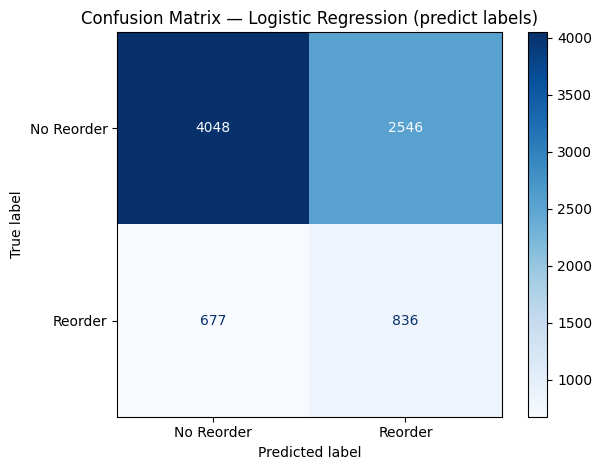

In [135]:
print("Training Logistic Regression (old style)...")

lr = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=5000,
    class_weight="balanced",
    solver="liblinear"  # tends to be stable for many sparse-like features
)

res_lr, mdl_lr = evaluate_model_oldstyle(lr, "Logistic Regression", X_train_df, y_train, X_val_df, y_val)
models["Logistic Regression"] = mdl_lr
results.append(res_lr)

print(res_lr["report"])
print(f"Accuracy: {res_lr['accuracy']:.4f} | ROC-AUC: {res_lr['roc_auc']:.4f}")
print(f"Best threshold (revenue): {res_lr['best_threshold']:.4f} | Send-rate: {res_lr['send_rate']:.3f}")
print(f"Revenue: €{res_lr['total_revenue']:.2f} | Avg: €{res_lr['avg_revenue']:.4f}")

plot_cm(y_val, res_lr["y_pred"], "Confusion Matrix — Logistic Regression (predict labels)")


# 5.2 Random Forest 

In [136]:
print("Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

result_rf, model_rf = evaluate_model(rf, 'Random Forest', X_train_df, y_train, X_val_df, y_val)
models['Random Forest'] = model_rf
results.append(result_rf)

print(f"Validation Accuracy: {result_rf['accuracy']:.4f}")
print(f"Validation ROC-AUC: {result_rf['roc_auc']:.4f}")
print(f"Best Threshold: {result_rf['best_threshold']:.4f}")
print(f"Total Revenue at Best Threshold: €{result_rf['total_revenue']:.2f}")
print(f"Average Revenue: €{result_rf['avg_revenue']:.4f}")


Training Random Forest...
Validation Accuracy: 0.3957
Validation ROC-AUC: 0.6402
Best Threshold: 0.4800
Total Revenue at Best Threshold: €2016.25
Average Revenue: €0.2487


### 5.3 Gradient Boosting


In [137]:
print("Training Gradient Boosting...")
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)

result_gb, model_gb = evaluate_model(gb, 'Gradient Boosting', X_train_df, y_train, X_val_df, y_val)
models['Gradient Boosting'] = model_gb
results.append(result_gb)

print(f"Validation Accuracy: {result_gb['accuracy']:.4f}")
print(f"Validation ROC-AUC: {result_gb['roc_auc']:.4f}")
print(f"Best Threshold: {result_gb['best_threshold']:.4f}")
print(f"Total Revenue at Best Threshold: €{result_gb['total_revenue']:.2f}")
print(f"Average Revenue: €{result_gb['avg_revenue']:.4f}")


Training Gradient Boosting...
Validation Accuracy: 0.3413
Validation ROC-AUC: 0.6416
Best Threshold: 0.2000
Total Revenue at Best Threshold: €2020.00
Average Revenue: €0.2492


### 5.4 K-Nearest Neighbors (with scaling)


Training K-Nearest Neighbors (with StandardScaler)...
Validation Accuracy: 0.3165
Validation ROC-AUC: 0.5543
Best Threshold: 0.2800
Total Revenue at Best Threshold: €1082.50
Average Revenue: €0.1335


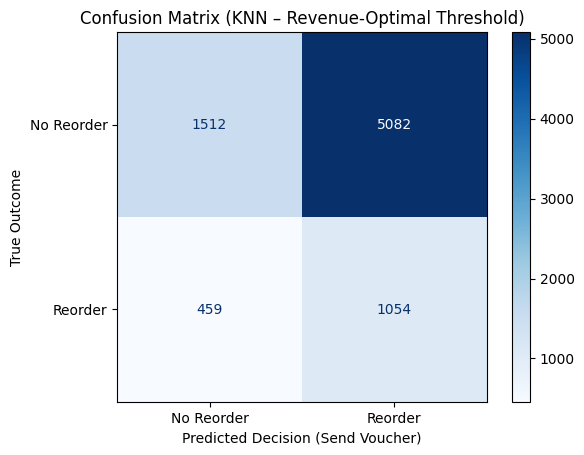

In [138]:
print("Training K-Nearest Neighbors (with StandardScaler)...")
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance'))
])

result_knn, model_knn = evaluate_model(knn_pipeline, 'KNN', X_train_df, y_train, X_val_df, y_val)
models['KNN'] = model_knn
results.append(result_knn)

print(f"Validation Accuracy: {result_knn['accuracy']:.4f}")
print(f"Validation ROC-AUC: {result_knn['roc_auc']:.4f}")
print(f"Best Threshold: {result_knn['best_threshold']:.4f}")
print(f"Total Revenue at Best Threshold: €{result_knn['total_revenue']:.2f}")
print(f"Average Revenue: €{result_knn['avg_revenue']:.4f}")



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict probabilities on validation set
p_val_knn = model_knn.predict_proba(X_val_df)[:, 1]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict probabilities on validation set
p_val_knn = model_knn.predict_proba(X_val_df)[:, 1]

best_t = result_knn["best_threshold"]

# Decision: send voucher if probability of reorder is below threshold
y_pred_knn = (p_val_knn < best_t).astype(int)


cm_knn = confusion_matrix(y_val, y_pred_knn)


disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_knn,
    display_labels=["No Reorder", "Reorder"]
)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (KNN – Revenue-Optimal Threshold)")
plt.xlabel("Predicted Decision (Send Voucher)")
plt.ylabel("True Outcome")
plt.show()


### 5.5 XGBoost or HistGradientBoosting


In [139]:
if XGBOOST_AVAILABLE:
    print("Training XGBoost...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    result_xgb, model_xgb = evaluate_model(xgb_model, 'XGBoost', X_train_df, y_train, X_val_df, y_val)
    models['XGBoost'] = model_xgb
    results.append(result_xgb)
    
    print(f"Validation Accuracy: {result_xgb['accuracy']:.4f}")
    print(f"Validation ROC-AUC: {result_xgb['roc_auc']:.4f}")
    print(f"Best Threshold: {result_xgb['best_threshold']:.4f}")
    print(f"Total Revenue at Best Threshold: €{result_xgb['total_revenue']:.2f}")
    print(f"Average Revenue: €{result_xgb['avg_revenue']:.4f}")
else:
    print("Training HistGradientBoostingClassifier (XGBoost fallback)...")
    hgb = HistGradientBoostingClassifier(
        max_iter=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_STATE
    )
    
    result_hgb, model_hgb = evaluate_model(hgb, 'HistGradientBoosting', X_train_df, y_train, X_val_df, y_val)
    models['HistGradientBoosting'] = model_hgb
    results.append(result_hgb)
    
    print(f"Validation Accuracy: {result_hgb['accuracy']:.4f}")
    print(f"Validation ROC-AUC: {result_hgb['roc_auc']:.4f}")
    print(f"Best Threshold: {result_hgb['best_threshold']:.4f}")
    print(f"Total Revenue at Best Threshold: €{result_hgb['total_revenue']:.2f}")
    print(f"Average Revenue: €{result_hgb['avg_revenue']:.4f}")


Training XGBoost...
Validation Accuracy: 0.3789
Validation ROC-AUC: 0.6427
Best Threshold: 0.1900
Total Revenue at Best Threshold: €2021.25
Average Revenue: €0.2493


### 5.6 Hyperparameter Tuning with Optuna

Tune hyperparameters for a strong model (XGBoost or Random Forest) using Optuna, optimizing for **validation revenue**.


In [140]:
if OPTUNA_AVAILABLE:
    print("Setting up Optuna hyperparameter tuning...")
    
    # Choose model to tune (prefer XGBoost if available, else Random Forest)
    if XGBOOST_AVAILABLE:
        model_to_tune = 'XGBoost'
        
        def objective_xgb(trial):
            """Optuna objective for XGBoost, maximizing validation revenue."""
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'random_state': RANDOM_STATE,
                'n_jobs': -1,
                'eval_metric': 'logloss'
            }
            
            model = xgb.XGBClassifier(**params)
            model.fit(X_train_df, y_train)
            
            # Get probabilities
            y_pred_proba = model.predict_proba(X_val_df)[:, 1]
            
            # Optimize threshold to maximize revenue
            best_threshold, best_revenue, _ = optimize_threshold(y_val, y_pred_proba)
            
            return best_revenue  # Optuna maximizes, so return revenue directly
        
        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
        )
        
        print(f"Running Optuna optimization for {model_to_tune} (maximizing validation revenue)...")
        print("This may take several minutes...")
        
        study.optimize(objective_xgb, n_trials=60, show_progress_bar=True)
        
        print(f"\nBest trial revenue: €{study.best_value:.2f}")
        print(f"Best parameters: {study.best_params}")
        
        # Train final model with best parameters
        best_params = study.best_params.copy()
        best_params['random_state'] = RANDOM_STATE
        best_params['n_jobs'] = -1
        best_params['eval_metric'] = 'logloss'
        
        xgb_tuned = xgb.XGBClassifier(**best_params)
        result_xgb_tuned, model_xgb_tuned = evaluate_model(
            xgb_tuned, 'XGBoost (Optuna Tuned)', X_train_df, y_train, X_val_df, y_val
        )
        models['XGBoost (Optuna Tuned)'] = model_xgb_tuned
        results.append(result_xgb_tuned)
        
        print(f"\nTuned Model Performance:")
        print(f"Validation Accuracy: {result_xgb_tuned['accuracy']:.4f}")
        print(f"Validation ROC-AUC: {result_xgb_tuned['roc_auc']:.4f}")
        print(f"Best Threshold: {result_xgb_tuned['best_threshold']:.4f}")
        print(f"Total Revenue at Best Threshold: €{result_xgb_tuned['total_revenue']:.2f}")
        print(f"Average Revenue: €{result_xgb_tuned['avg_revenue']:.4f}")
        
    else:
        # Tune Random Forest
        model_to_tune = 'Random Forest'
        
        def objective_rf(trial):
            """Optuna objective for Random Forest, maximizing validation revenue."""
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 5, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'class_weight': 'balanced',
                'random_state': RANDOM_STATE,
                'n_jobs': -1
            }
            
            model = RandomForestClassifier(**params)
            model.fit(X_train_df, y_train)
            
            y_pred_proba = model.predict_proba(X_val_df)[:, 1]
            best_threshold, best_revenue, _ = optimize_threshold(y_val, y_pred_proba)
            
            return best_revenue
        
        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
        )
        
        print(f"Running Optuna optimization for {model_to_tune} (maximizing validation revenue)...")
        print("This may take several minutes...")
        
        study.optimize(objective_rf, n_trials=60, show_progress_bar=True)
        
        print(f"\nBest trial revenue: €{study.best_value:.2f}")
        print(f"Best parameters: {study.best_params}")
        
        # Train final model
        best_params = study.best_params.copy()
        best_params['random_state'] = RANDOM_STATE
        best_params['n_jobs'] = -1
        
        rf_tuned = RandomForestClassifier(**best_params)
        result_rf_tuned, model_rf_tuned = evaluate_model(
            rf_tuned, 'Random Forest (Optuna Tuned)', X_train_df, y_train, X_val_df, y_val
        )
        models['Random Forest (Optuna Tuned)'] = model_rf_tuned
        results.append(result_rf_tuned)
        
        print(f"\nTuned Model Performance:")
        print(f"Validation Accuracy: {result_rf_tuned['accuracy']:.4f}")
        print(f"Validation ROC-AUC: {result_rf_tuned['roc_auc']:.4f}")
        print(f"Best Threshold: {result_rf_tuned['best_threshold']:.4f}")
        print(f"Total Revenue at Best Threshold: €{result_rf_tuned['total_revenue']:.2f}")
        print(f"Average Revenue: €{result_rf_tuned['avg_revenue']:.4f}")
else:
    print("Optuna not available. Skipping hyperparameter tuning.")


[I 2025-12-31 18:14:35,969] A new study created in memory with name: no-name-f44c171d-1d23-481b-83ef-f48347704279


Setting up Optuna hyperparameter tuning...
Running Optuna optimization for XGBoost (maximizing validation revenue)...
This may take several minutes...


Best trial: 1. Best value: 1843.75:   3%|▎         | 2/60 [00:00<00:09,  6.05it/s]

[I 2025-12-31 18:14:36,216] Trial 0 finished with value: 1498.75 and parameters: {'n_estimators': 144, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481}. Best is trial 0 with value: 1498.75.
[I 2025-12-31 18:14:36,325] Trial 1 finished with value: 1843.75 and parameters: {'n_estimators': 64, 'learning_rate': 0.19030368381735815, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978}. Best is trial 1 with value: 1843.75.


Best trial: 2. Best value: 2032.5:   5%|▌         | 3/60 [00:00<00:11,  4.96it/s] 

[I 2025-12-31 18:14:36,569] Trial 2 finished with value: 2032.5 and parameters: {'n_estimators': 258, 'learning_rate': 0.020589728197687916, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951}. Best is trial 2 with value: 2032.5.


Best trial: 3. Best value: 2100:   8%|▊         | 5/60 [00:01<00:10,  5.04it/s]  

[I 2025-12-31 18:14:36,814] Trial 3 finished with value: 2100.0 and parameters: {'n_estimators': 158, 'learning_rate': 0.02692655251486473, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767}. Best is trial 3 with value: 2100.0.
[I 2025-12-31 18:14:36,977] Trial 4 finished with value: 2063.75 and parameters: {'n_estimators': 164, 'learning_rate': 0.14447746112718687, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.836965827544817, 'colsample_bytree': 0.6185801650879991}. Best is trial 3 with value: 2100.0.


Best trial: 3. Best value: 2100:  10%|█         | 6/60 [00:01<00:10,  5.27it/s]

[I 2025-12-31 18:14:37,149] Trial 5 finished with value: 2025.0 and parameters: {'n_estimators': 202, 'learning_rate': 0.0178601378893971, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9862528132298237, 'colsample_bytree': 0.9233589392465844}. Best is trial 3 with value: 2100.0.


Best trial: 3. Best value: 2100:  12%|█▏        | 7/60 [00:01<00:10,  4.87it/s]

[I 2025-12-31 18:14:37,386] Trial 6 finished with value: 2086.25 and parameters: {'n_estimators': 126, 'learning_rate': 0.013940346079873234, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508}. Best is trial 3 with value: 2100.0.
[I 2025-12-31 18:14:37,465] Trial 7 finished with value: 1860.0 and parameters: {'n_estimators': 58, 'learning_rate': 0.22038218939289875, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7246844304357644, 'colsample_bytree': 0.8080272084711243}. Best is trial 3 with value: 2100.0.


Best trial: 3. Best value: 2100:  17%|█▋        | 10/60 [00:02<00:10,  4.80it/s]

[I 2025-12-31 18:14:37,866] Trial 8 finished with value: 2005.0 and parameters: {'n_estimators': 187, 'learning_rate': 0.01875220945578641, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.9757995766256756, 'colsample_bytree': 0.9579309401710595}. Best is trial 3 with value: 2100.0.
[I 2025-12-31 18:14:38,035] Trial 9 finished with value: 1950.0 and parameters: {'n_estimators': 200, 'learning_rate': 0.22999586428143728, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057}. Best is trial 3 with value: 2100.0.


Best trial: 3. Best value: 2100:  18%|█▊        | 11/60 [00:02<00:15,  3.15it/s]

[I 2025-12-31 18:14:38,652] Trial 10 finished with value: 1748.75 and parameters: {'n_estimators': 287, 'learning_rate': 0.048190978341949964, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8391524267229545, 'colsample_bytree': 0.8760988294276582}. Best is trial 3 with value: 2100.0.


Best trial: 3. Best value: 2100:  22%|██▏       | 13/60 [00:03<00:12,  3.87it/s]

[I 2025-12-31 18:14:38,886] Trial 11 finished with value: 1998.75 and parameters: {'n_estimators': 114, 'learning_rate': 0.010662940724293503, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.727109668050402, 'colsample_bytree': 0.729779740292822}. Best is trial 3 with value: 2100.0.
[I 2025-12-31 18:14:39,053] Trial 12 finished with value: 2040.0 and parameters: {'n_estimators': 114, 'learning_rate': 0.04081573424121769, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.7815343585324473, 'colsample_bytree': 0.7350101505739597}. Best is trial 3 with value: 2100.0.


Best trial: 3. Best value: 2100:  23%|██▎       | 14/60 [00:03<00:11,  4.07it/s]

[I 2025-12-31 18:14:39,267] Trial 13 finished with value: 2003.75 and parameters: {'n_estimators': 113, 'learning_rate': 0.010165626464918528, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.6740522907106167, 'colsample_bytree': 0.8610724800899924}. Best is trial 3 with value: 2100.0.


Best trial: 3. Best value: 2100:  25%|██▌       | 15/60 [00:03<00:12,  3.68it/s]

[I 2025-12-31 18:14:39,601] Trial 14 finished with value: 2018.75 and parameters: {'n_estimators': 225, 'learning_rate': 0.03371644959729359, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7834938498368463, 'colsample_bytree': 0.7564778880144696}. Best is trial 3 with value: 2100.0.


Best trial: 3. Best value: 2100:  28%|██▊       | 17/60 [00:04<00:10,  4.21it/s]

[I 2025-12-31 18:14:39,893] Trial 15 finished with value: 1758.75 and parameters: {'n_estimators': 145, 'learning_rate': 0.08350593523459465, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.6714645958042158, 'colsample_bytree': 0.6807000494372463}. Best is trial 3 with value: 2100.0.
[I 2025-12-31 18:14:40,036] Trial 16 finished with value: 1992.5 and parameters: {'n_estimators': 89, 'learning_rate': 0.028069002597357614, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.9110846414027766, 'colsample_bytree': 0.8604911724169199}. Best is trial 3 with value: 2100.0.


Best trial: 3. Best value: 2100:  30%|███       | 18/60 [00:04<00:11,  3.82it/s]

[I 2025-12-31 18:14:40,355] Trial 17 finished with value: 1802.5 and parameters: {'n_estimators': 154, 'learning_rate': 0.0850956724116098, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.7480331495162676, 'colsample_bytree': 0.7940341779357337}. Best is trial 3 with value: 2100.0.


Best trial: 18. Best value: 2137.5:  32%|███▏      | 19/60 [00:04<00:12,  3.17it/s]

[I 2025-12-31 18:14:40,793] Trial 18 finished with value: 2137.5 and parameters: {'n_estimators': 241, 'learning_rate': 0.015435228996204873, 'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.6566336966609404, 'colsample_bytree': 0.6905473019872458}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  33%|███▎      | 20/60 [00:05<00:12,  3.23it/s]

[I 2025-12-31 18:14:41,094] Trial 19 finished with value: 2048.75 and parameters: {'n_estimators': 239, 'learning_rate': 0.025484045425698012, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6929755003346987, 'colsample_bytree': 0.6732132011401761}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  35%|███▌      | 21/60 [00:05<00:13,  2.87it/s]

[I 2025-12-31 18:14:41,531] Trial 20 finished with value: 1925.0 and parameters: {'n_estimators': 297, 'learning_rate': 0.0670842440427765, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.8343872902276027, 'colsample_bytree': 0.6094781646023328}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  37%|███▋      | 22/60 [00:05<00:13,  2.89it/s]

[I 2025-12-31 18:14:41,873] Trial 21 finished with value: 2091.25 and parameters: {'n_estimators': 176, 'learning_rate': 0.014403121015645923, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.636612601300042, 'colsample_bytree': 0.7660093644266606}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  38%|███▊      | 23/60 [00:06<00:12,  2.97it/s]

[I 2025-12-31 18:14:42,189] Trial 22 finished with value: 2130.0 and parameters: {'n_estimators': 218, 'learning_rate': 0.01483460884187148, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6400268681282894, 'colsample_bytree': 0.6979300771033013}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  40%|████      | 24/60 [00:06<00:11,  3.02it/s]

[I 2025-12-31 18:14:42,507] Trial 23 finished with value: 2011.25 and parameters: {'n_estimators': 224, 'learning_rate': 0.024671362759401867, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.6947348674282242, 'colsample_bytree': 0.7009632101880053}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  42%|████▏     | 25/60 [00:06<00:11,  3.07it/s]

[I 2025-12-31 18:14:42,821] Trial 24 finished with value: 2068.75 and parameters: {'n_estimators': 265, 'learning_rate': 0.014678598105529277, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.6094866781690738, 'colsample_bytree': 0.6392704093643968}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  43%|████▎     | 26/60 [00:07<00:10,  3.10it/s]

[I 2025-12-31 18:14:43,137] Trial 25 finished with value: 2065.0 and parameters: {'n_estimators': 207, 'learning_rate': 0.034737902449289766, 'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.7580235260582388, 'colsample_bytree': 0.6960589832510096}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  45%|████▌     | 27/60 [00:07<00:10,  3.05it/s]

[I 2025-12-31 18:14:43,475] Trial 26 finished with value: 2072.5 and parameters: {'n_estimators': 249, 'learning_rate': 0.01305247459141817, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.7015599996147064, 'colsample_bytree': 0.6489775881072541}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  47%|████▋     | 28/60 [00:08<00:12,  2.62it/s]

[I 2025-12-31 18:14:43,985] Trial 27 finished with value: 1978.75 and parameters: {'n_estimators': 273, 'learning_rate': 0.020922834624097098, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.6422684164238962, 'colsample_bytree': 0.7159915167653711}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  48%|████▊     | 29/60 [00:08<00:10,  2.89it/s]

[I 2025-12-31 18:14:44,248] Trial 28 finished with value: 2086.25 and parameters: {'n_estimators': 228, 'learning_rate': 0.030158230341036107, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.6354444361887552, 'colsample_bytree': 0.7509755692420937}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  50%|█████     | 30/60 [00:08<00:09,  3.08it/s]

[I 2025-12-31 18:14:44,521] Trial 29 finished with value: 2013.75 and parameters: {'n_estimators': 183, 'learning_rate': 0.04996335256974965, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6662533834098119, 'colsample_bytree': 0.658979152876389}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  52%|█████▏    | 31/60 [00:08<00:09,  3.19it/s]

[I 2025-12-31 18:14:44,809] Trial 30 finished with value: 2071.25 and parameters: {'n_estimators': 215, 'learning_rate': 0.017255775988417894, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6919570332924256, 'colsample_bytree': 0.768802589553696}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  53%|█████▎    | 32/60 [00:09<00:09,  3.09it/s]

[I 2025-12-31 18:14:45,158] Trial 31 finished with value: 2126.25 and parameters: {'n_estimators': 170, 'learning_rate': 0.012071728768611263, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.6390423213638492, 'colsample_bytree': 0.7728600075457849}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  55%|█████▌    | 33/60 [00:09<00:07,  3.40it/s]

[I 2025-12-31 18:14:45,381] Trial 32 finished with value: 2007.5 and parameters: {'n_estimators': 136, 'learning_rate': 0.010793089235821694, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.6008486744025745, 'colsample_bytree': 0.6987570695861395}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  57%|█████▋    | 34/60 [00:09<00:07,  3.38it/s]

[I 2025-12-31 18:14:45,682] Trial 33 finished with value: 2112.5 and parameters: {'n_estimators': 169, 'learning_rate': 0.022108040687455383, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6511834094975162, 'colsample_bytree': 0.8327783766195997}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  58%|█████▊    | 35/60 [00:10<00:08,  3.12it/s]

[I 2025-12-31 18:14:46,061] Trial 34 finished with value: 2117.5 and parameters: {'n_estimators': 191, 'learning_rate': 0.012150566615038551, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6584145063789909, 'colsample_bytree': 0.8326130634948293}. Best is trial 18 with value: 2137.5.


Best trial: 18. Best value: 2137.5:  60%|██████    | 36/60 [00:10<00:08,  2.75it/s]

[I 2025-12-31 18:14:46,526] Trial 35 finished with value: 2111.25 and parameters: {'n_estimators': 245, 'learning_rate': 0.01219705038573949, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.6238955281168065, 'colsample_bytree': 0.8337740073640343}. Best is trial 18 with value: 2137.5.


Best trial: 36. Best value: 2183.75:  62%|██████▏   | 37/60 [00:10<00:08,  2.70it/s]

[I 2025-12-31 18:14:46,911] Trial 36 finished with value: 2183.75 and parameters: {'n_estimators': 193, 'learning_rate': 0.01697254149246836, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.6699434473470196, 'colsample_bytree': 0.7764617850750943}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  63%|██████▎   | 38/60 [00:11<00:08,  2.54it/s]

[I 2025-12-31 18:14:47,357] Trial 37 finished with value: 2036.25 and parameters: {'n_estimators': 208, 'learning_rate': 0.01602017823246093, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.6724730746419627, 'colsample_bytree': 0.7869469379407485}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  65%|██████▌   | 39/60 [00:11<00:08,  2.55it/s]

[I 2025-12-31 18:14:47,745] Trial 38 finished with value: 1670.0 and parameters: {'n_estimators': 236, 'learning_rate': 0.1505000672963418, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.6033809724160212, 'colsample_bytree': 0.7745002774891504}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  67%|██████▋   | 40/60 [00:12<00:07,  2.85it/s]

[I 2025-12-31 18:14:47,999] Trial 39 finished with value: 2035.0 and parameters: {'n_estimators': 258, 'learning_rate': 0.01906265619495631, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.9019936367500316, 'colsample_bytree': 0.6326856595062711}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  68%|██████▊   | 41/60 [00:12<00:06,  2.97it/s]

[I 2025-12-31 18:14:48,304] Trial 40 finished with value: 2083.75 and parameters: {'n_estimators': 193, 'learning_rate': 0.015904020920976536, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.713552298121969, 'colsample_bytree': 0.7160134725605608}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  70%|███████   | 42/60 [00:12<00:06,  2.87it/s]

[I 2025-12-31 18:14:48,681] Trial 41 finished with value: 2126.25 and parameters: {'n_estimators': 191, 'learning_rate': 0.012609746103711445, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6574858492459612, 'colsample_bytree': 0.8229565955283673}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  72%|███████▏  | 43/60 [00:13<00:05,  2.85it/s]

[I 2025-12-31 18:14:49,038] Trial 42 finished with value: 2095.0 and parameters: {'n_estimators': 173, 'learning_rate': 0.01244336728586747, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.6301893530990631, 'colsample_bytree': 0.8956636836729547}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  73%|███████▎  | 44/60 [00:13<00:06,  2.60it/s]

[I 2025-12-31 18:14:49,502] Trial 43 finished with value: 2072.5 and parameters: {'n_estimators': 218, 'learning_rate': 0.02263233794590761, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.68079398360128, 'colsample_bytree': 0.8162677862607135}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  75%|███████▌  | 45/60 [00:13<00:05,  2.67it/s]

[I 2025-12-31 18:14:49,853] Trial 44 finished with value: 2150.0 and parameters: {'n_estimators': 198, 'learning_rate': 0.017046883944325165, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.745200587346652, 'colsample_bytree': 0.8154313300178044}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  77%|███████▋  | 46/60 [00:14<00:04,  2.88it/s]

[I 2025-12-31 18:14:50,134] Trial 45 finished with value: 2122.5 and parameters: {'n_estimators': 158, 'learning_rate': 0.01828871631416174, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.7380983001240753, 'colsample_bytree': 0.7883838753824317}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  78%|███████▊  | 47/60 [00:14<00:04,  2.90it/s]

[I 2025-12-31 18:14:50,475] Trial 46 finished with value: 1465.0 and parameters: {'n_estimators': 202, 'learning_rate': 0.2931797530356798, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.7650723155381586, 'colsample_bytree': 0.9967825861452995}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  80%|████████  | 48/60 [00:14<00:04,  2.94it/s]

[I 2025-12-31 18:14:50,804] Trial 47 finished with value: 2046.25 and parameters: {'n_estimators': 183, 'learning_rate': 0.010131485628899888, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8052419592476355, 'colsample_bytree': 0.8551707863359662}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  82%|████████▏ | 49/60 [00:15<00:03,  2.85it/s]

[I 2025-12-31 18:14:51,181] Trial 48 finished with value: 2071.25 and parameters: {'n_estimators': 216, 'learning_rate': 0.01636035862126483, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.7155892929357864, 'colsample_bytree': 0.735832073830601}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  83%|████████▎ | 50/60 [00:15<00:03,  2.91it/s]

[I 2025-12-31 18:14:51,506] Trial 49 finished with value: 2135.0 and parameters: {'n_estimators': 233, 'learning_rate': 0.020658340183842768, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.6213597565326758, 'colsample_bytree': 0.9396080438841327}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  85%|████████▌ | 51/60 [00:15<00:02,  3.02it/s]

[I 2025-12-31 18:14:51,807] Trial 50 finished with value: 2043.75 and parameters: {'n_estimators': 232, 'learning_rate': 0.03325656896284049, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.6239338584678438, 'colsample_bytree': 0.939400026109403}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  87%|████████▋ | 52/60 [00:16<00:02,  2.98it/s]

[I 2025-12-31 18:14:52,154] Trial 51 finished with value: 2050.0 and parameters: {'n_estimators': 254, 'learning_rate': 0.019892650187349755, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.6491275514412742, 'colsample_bytree': 0.9008905837388765}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  88%|████████▊ | 53/60 [00:16<00:02,  3.00it/s]

[I 2025-12-31 18:14:52,480] Trial 52 finished with value: 2143.75 and parameters: {'n_estimators': 271, 'learning_rate': 0.014577598010124192, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.6227873992523719, 'colsample_bytree': 0.9640058966403248}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  90%|█████████ | 54/60 [00:16<00:01,  3.01it/s]

[I 2025-12-31 18:14:52,811] Trial 53 finished with value: 2115.0 and parameters: {'n_estimators': 276, 'learning_rate': 0.014450058733583137, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.6176663194275933, 'colsample_bytree': 0.9640774177494089}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  92%|█████████▏| 55/60 [00:17<00:01,  3.02it/s]

[I 2025-12-31 18:14:53,141] Trial 54 finished with value: 2100.0 and parameters: {'n_estimators': 281, 'learning_rate': 0.02538189860342527, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.6857271562362997, 'colsample_bytree': 0.9690347236667186}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  93%|█████████▎| 56/60 [00:17<00:01,  3.19it/s]

[I 2025-12-31 18:14:53,411] Trial 55 finished with value: 2062.5 and parameters: {'n_estimators': 265, 'learning_rate': 0.03943715510012484, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6164919605042349, 'colsample_bytree': 0.9313486627082191}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  95%|█████████▌| 57/60 [00:17<00:00,  3.40it/s]

[I 2025-12-31 18:14:53,661] Trial 56 finished with value: 2055.0 and parameters: {'n_estimators': 242, 'learning_rate': 0.017913220866759474, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.6623582301601164, 'colsample_bytree': 0.9473591075794892}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  97%|█████████▋| 58/60 [00:18<00:00,  3.12it/s]

[I 2025-12-31 18:14:54,042] Trial 57 finished with value: 2103.75 and parameters: {'n_estimators': 297, 'learning_rate': 0.023359070849154586, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7336996836972831, 'colsample_bytree': 0.9160939258841969}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75:  98%|█████████▊| 59/60 [00:18<00:00,  3.25it/s]

[I 2025-12-31 18:14:54,321] Trial 58 finished with value: 2048.75 and parameters: {'n_estimators': 225, 'learning_rate': 0.014188526711938121, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.813702899488772, 'colsample_bytree': 0.9811111533664826}. Best is trial 36 with value: 2183.75.


Best trial: 36. Best value: 2183.75: 100%|██████████| 60/60 [00:18<00:00,  3.20it/s]


[I 2025-12-31 18:14:54,716] Trial 59 finished with value: 1952.5 and parameters: {'n_estimators': 265, 'learning_rate': 0.027917903884708616, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.709078472576203, 'colsample_bytree': 0.6763534290462094}. Best is trial 36 with value: 2183.75.

Best trial revenue: €2183.75
Best parameters: {'n_estimators': 193, 'learning_rate': 0.01697254149246836, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.6699434473470196, 'colsample_bytree': 0.7764617850750943}

Tuned Model Performance:
Validation Accuracy: 0.3422
Validation ROC-AUC: 0.6459
Best Threshold: 0.2000
Total Revenue at Best Threshold: €2183.75
Average Revenue: €0.2694


## 6. Threshold Optimization

Threshold optimization is performed during model evaluation. Here we visualize the threshold-revenue relationship for the best model.


Best model by revenue: XGBoost (Optuna Tuned)
Best threshold: 0.2000
Total revenue: €2183.75
Average revenue: €0.2694


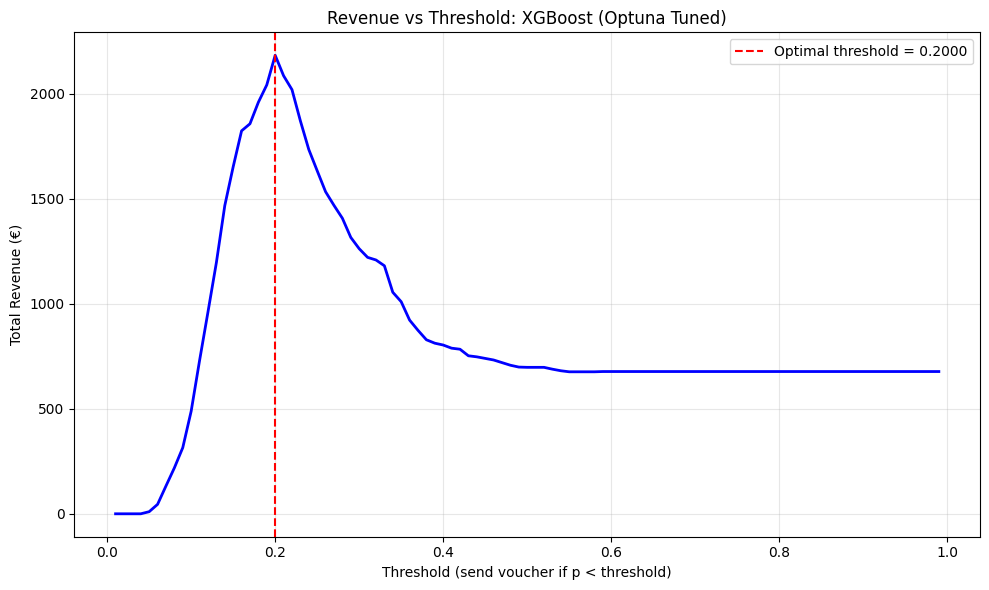

In [141]:
# Find best model by revenue
best_model_result = max(results, key=lambda x: x['total_revenue'])
best_model_name = best_model_result['model_name']

print(f"Best model by revenue: {best_model_name}")
print(f"Best threshold: {best_model_result['best_threshold']:.4f}")
print(f"Total revenue: €{best_model_result['total_revenue']:.2f}")
print(f"Average revenue: €{best_model_result['avg_revenue']:.4f}")

# Plot threshold-revenue curve for best model
threshold_df = best_model_result['threshold_results']

plt.figure(figsize=(10, 6))
plt.plot(threshold_df['threshold'], threshold_df['total_revenue'], 'b-', linewidth=2)
plt.axvline(best_model_result['best_threshold'], color='r', linestyle='--', 
            label=f'Optimal threshold = {best_model_result["best_threshold"]:.4f}')
plt.xlabel('Threshold (send voucher if p < threshold)')
plt.ylabel('Total Revenue (€)')
plt.title(f'Revenue vs Threshold: {best_model_name}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## 7. Model Comparison Table


In [142]:
# Create comparison DataFrame
comparison_data = []
for r in results:
    comparison_data.append({
        'Model': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1': r['f1'],
        'ROC-AUC': r['roc_auc'],
        'Best Threshold': r['best_threshold'],
        'Total Revenue (€)': r['total_revenue'],
        'Avg Revenue (€)': r['avg_revenue']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Total Revenue (€)', ascending=False)

print("Model Comparison (sorted by Total Revenue):")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Save comparison table
comparison_df.to_csv('model_comparison.csv', index=False)
print("\nComparison table saved to 'model_comparison.csv'")


Model Comparison (sorted by Total Revenue):
                 Model  Accuracy  Precision   Recall       F1  ROC-AUC  Best Threshold  Total Revenue (€)  Avg Revenue (€)
XGBoost (Optuna Tuned)  0.342173   0.132834 0.456709 0.205808 0.645925            0.20            2183.75         0.269366
               XGBoost  0.378932   0.132513 0.419696 0.201427 0.642657            0.19            2021.25         0.249322
     Gradient Boosting  0.341310   0.139030 0.487112 0.216319 0.641623            0.20            2020.00         0.249167
         Random Forest  0.395707   0.129378 0.390615 0.194376 0.640219            0.48            2016.25         0.248705
   Logistic Regression  0.602442   0.247191 0.552545 0.341573 0.619811            0.50            1675.00         0.206612
                   KNN  0.316517   0.171773 0.696629 0.275592 0.554299            0.28            1082.50         0.133527

Comparison table saved to 'model_comparison.csv'


In [143]:
# Detailed classification reports
print("\nDetailed Classification Reports:")
print("=" * 100)
for r in results:
    model_name = r['model_name']
    y_pred_proba = r['y_pred_proba']
    best_threshold = r['best_threshold']
    
    # Predictions at optimal threshold
    y_pred_optimal = (y_pred_proba < best_threshold).astype(int)  # Send if prob < threshold
    
    print(f"\n{model_name} (threshold={best_threshold:.4f}):")
    print("-" * 80)
    print(classification_report(y_val, y_pred_optimal, target_names=['No Reorder', 'Reorder']))
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred_optimal)
    print(f"Confusion Matrix:")
    print(f"                Predicted")
    print(f"              No Reorder  Reorder")
    print(f"Actual No Reorder    {cm[0,0]:5d}    {cm[0,1]:5d}")
    print(f"Actual Reorder       {cm[1,0]:5d}    {cm[1,1]:5d}")
    print()



Detailed Classification Reports:


KeyError: 'y_pred_proba'

## 8. Final Model Selection

Select the best model based on validation revenue.


In [145]:
# Select best model
best_model_name = best_model_result['model_name']
best_model = models[best_model_name]
best_threshold = best_model_result['best_threshold']

print(f"Selected Best Model: {best_model_name}")
print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Validation Total Revenue: €{best_model_result['total_revenue']:.2f}")
print(f"Validation Average Revenue: €{best_model_result['avg_revenue']:.4f}")
print(f"Validation Accuracy: {best_model_result['accuracy']:.4f}")
print(f"Validation ROC-AUC: {best_model_result['roc_auc']:.4f}")

# Save best model and threshold
joblib.dump(best_model, 'best_model.joblib')
print("\nBest model saved to 'best_model.joblib'")

with open('best_threshold.json', 'w') as f:
    json.dump({'threshold': float(best_threshold), 'model_name': best_model_name}, f, indent=2)
print("Best threshold saved to 'best_threshold.json'")


Selected Best Model: XGBoost (Optuna Tuned)
Optimal Threshold: 0.2000
Validation Total Revenue: €2183.75
Validation Average Revenue: €0.2694
Validation Accuracy: 0.3422
Validation ROC-AUC: 0.6459

Best model saved to 'best_model.joblib'
Best threshold saved to 'best_threshold.json'


## 9. Predict on Unlabeled Test Set and Export Submission

Train the final model on the full labeled data (train + validation) and generate predictions for the test set.


In [146]:
# Combine train and validation for final training
X_full = pd.concat([X_train_df, X_val_df], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

print(f"Full training set shape: {X_full.shape}")
print(f"Full training target distribution: {y_full.value_counts().to_dict()}")

# Retrain best model on full data
print(f"\nRetraining {best_model_name} on full labeled data...")

# Get the model class and parameters
if 'XGBoost' in best_model_name:
    if hasattr(best_model, 'get_params'):
        final_model = xgb.XGBClassifier(**best_model.get_params())
    else:
        # Fallback: use default parameters
        final_model = xgb.XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)
elif 'Random Forest' in best_model_name:
    if hasattr(best_model, 'get_params'):
        final_model = RandomForestClassifier(**best_model.get_params())
    else:
        final_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
elif 'Gradient Boosting' in best_model_name:
    if hasattr(best_model, 'get_params'):
        final_model = GradientBoostingClassifier(**best_model.get_params())
    else:
        final_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
elif 'KNN' in best_model_name:
    final_model = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance'))
    ])
elif 'Logistic' in best_model_name:
    if hasattr(best_model, 'get_params'):
        final_model = LogisticRegression(**best_model.get_params())
    else:
        final_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
else:
    # Generic fallback: clone the model
    from sklearn.base import clone
    final_model = clone(best_model)

final_model.fit(X_full, y_full)
print("Model retrained on full data.")

# Predict on test set
print("\nGenerating predictions on test set...")
p_test = final_model.predict_proba(X_test_df)[:, 1]

# Ensure probabilities are valid
assert np.all((p_test >= 0) & (p_test <= 1)), "Invalid probabilities detected"

# Apply decision rule: send_voucher = 1 if p < threshold
voucher_decision = (p_test < best_threshold).astype(int)

print(f"Test set predictions generated.")
print(f"Number of vouchers to send: {voucher_decision.sum()} out of {len(voucher_decision)} ({voucher_decision.mean()*100:.2f}%)")

# Create submission DataFrame
# Note: If customernumber is not available in test, we'll use index
try:
    # Try to load test.csv to get customernumber if available
    test_raw = pd.read_csv('test.csv', sep=';', low_memory=False)
    if 'customernumber' in test_raw.columns:
        submission = pd.DataFrame({
            'customernumber': test_raw['customernumber'].values,
            'voucher_decision': voucher_decision
        })
    else:
        submission = pd.DataFrame({
            'customernumber': X_test_df.index,
            'voucher_decision': voucher_decision
        })
except:
    submission = pd.DataFrame({
        'customernumber': X_test_df.index,
        'voucher_decision': voucher_decision
    })

# Export submission
submission.to_csv('submission.csv', index=False)
print(f"\nSubmission file saved to 'submission.csv'")
print(f"Submission shape: {submission.shape}")
print(f"\nFirst few rows:")
print(submission.head(10))


Full training set shape: (32428, 62)
Full training target distribution: {0: 26377, 1: 6051}

Retraining XGBoost (Optuna Tuned) on full labeled data...
Model retrained on full data.

Generating predictions on test set...
Test set predictions generated.
Number of vouchers to send: 20811 out of 32427 (64.18%)

Submission file saved to 'submission.csv'
Submission shape: (32427, 2)

First few rows:
   customernumber  voucher_decision
0            6044                 1
1           36314                 0
2           41932                 0
3            3194                 1
4           35363                 1
5           35405                 1
6           39917                 1
7           39868                 1
8           52322                 1
9            3022                 1


## 10. Interpretability Hooks

Extract feature importances and coefficients for model interpretation.


In [147]:
# Feature importances for tree-based models
print("Feature Importances (Tree-based Models):")
print("=" * 80)

for model_name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_imp_df = pd.DataFrame({
            'feature': X_train_df.columns,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\n{model_name} - Top 15 Features:")
        print(feature_imp_df.head(15).to_string(index=False))
        
        # Save to CSV
        safe_name = model_name.replace(' ', '_').replace('(', '').replace(')', '')
        feature_imp_df.to_csv(f'feature_importance_{safe_name}.csv', index=False)

print("\n" + "=" * 80)


Feature Importances (Tree-based Models):

Random Forest - Top 15 Features:
                  feature  importance
                   weight    0.093544
                     remi    0.057986
              order_month    0.052865
      delivery_difference    0.048889
  promised_delivery_month    0.048410
              numberitems    0.043876
            order_weekday    0.034301
             newsletter_0    0.034143
                     case    0.033860
          shippingcosts_1    0.032762
                       w0    0.029627
             newsletter_1    0.029312
promised_delivery_weekday    0.028317
                       w1    0.025015
         account_age_days    0.019190

Gradient Boosting - Top 15 Features:
                  feature  importance
                   weight    0.156739
                     remi    0.068387
      delivery_difference    0.057419
  promised_delivery_month    0.052745
         account_age_days    0.040163
              numberitems    0.039421
             

In [148]:
# Coefficients for Logistic Regression
if 'Logistic Regression' in models:
    lr_model = models['Logistic Regression']
    if hasattr(lr_model, 'coef_'):
        coef_df = pd.DataFrame({
            'feature': X_train_df.columns,
            'coefficient': lr_model.coef_[0]
        }).sort_values('coefficient', key=abs, ascending=False)
        
        print("Logistic Regression - Top 20 Coefficients (by absolute value):")
        print("=" * 80)
        print(coef_df.head(20).to_string(index=False))
        
        coef_df.to_csv('logistic_regression_coefficients.csv', index=False)
        print("\nCoefficients saved to 'logistic_regression_coefficients.csv'")


Logistic Regression - Top 20 Coefficients (by absolute value):
        feature  coefficient
        entry_0    -0.451569
           remi     0.419541
        model_1     0.361425
        entry_1     0.346566
             w3     0.337481
      domain_10    -0.320760
        model_2    -0.308668
   newsletter_0    -0.272969
shippingcosts_1    -0.254389
       domain_6     0.248442
             w5     0.213490
   salutation_2    -0.197806
       domain_3    -0.188038
      voucher_1    -0.177549
   newsletter_1     0.167966
           used     0.164797
        model_3    -0.157760
            w10    -0.157453
       domain_7    -0.155619
shippingcosts_0     0.149386

Coefficients saved to 'logistic_regression_coefficients.csv'


In [149]:
# SHAP analysis placeholder
print("SHAP Analysis Setup:")
print("=" * 80)
print("\nTo perform SHAP analysis, install shap and run:")
print("\n```python")
print("import shap")
print("\n# For tree models:")
print(f"explainer = shap.TreeExplainer({best_model_name})")
print(f"shap_values = explainer.shap_values(X_val_df.iloc[:100])  # Sample for speed")
print(f"shap.summary_plot(shap_values, X_val_df.iloc[:100])")
print("\n# For other models:")
print(f"explainer = shap.KernelExplainer({best_model_name}.predict_proba, X_val_df.iloc[:100])")
print(f"shap_values = explainer.shap_values(X_val_df.iloc[:100])")
print("```")
print("\nNote: Store the trained model and feature matrix for SHAP analysis.")

# Save model and data for SHAP
shap_data = {
    'model': best_model,
    'X_val_sample': X_val_df.iloc[:100].values,  # Sample for SHAP
    'feature_names': X_train_df.columns.tolist()
}

joblib.dump(shap_data, 'shap_data.joblib')
print("\nModel and sample data saved to 'shap_data.joblib' for SHAP analysis.")


SHAP Analysis Setup:

To perform SHAP analysis, install shap and run:

```python
import shap

# For tree models:
explainer = shap.TreeExplainer(XGBoost (Optuna Tuned))
shap_values = explainer.shap_values(X_val_df.iloc[:100])  # Sample for speed
shap.summary_plot(shap_values, X_val_df.iloc[:100])

# For other models:
explainer = shap.KernelExplainer(XGBoost (Optuna Tuned).predict_proba, X_val_df.iloc[:100])
shap_values = explainer.shap_values(X_val_df.iloc[:100])
```

Note: Store the trained model and feature matrix for SHAP analysis.

Model and sample data saved to 'shap_data.joblib' for SHAP analysis.
